In [1]:
from astropy import units as u
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import ticker
import pandas as pd
from scipy.optimize import curve_fit

import lifesim
from lifesim.util.radiation import black_body

### Set options for Earth twin

In [2]:
temp_p = 265.  # in K
radius_p = 1.  # in earth rad
distance_s = 10.  # in pc

temp_s = 5778.  # in K
radius_s = 1.  # in sun rad
lat_s = 0.79  # in rad
z = 3  # in zodis

angsep = 0.1  # in arcsec
integration_time = 60*60

### Set up the LIFEsim bus

In [3]:
bus = lifesim.Bus()

bus.data.options.set_scenario('baseline')
bus.data.options.set_manual(spec_res=50)

instrument = lifesim.InstrumentPrt(name='inst')
bus.add_module(instrument)

instrument_base = lifesim.Instrument(name='inst_base')
bus.add_module(instrument_base)

transm = lifesim.TransmissionMap(name='transm')
bus.add_module(transm)

exo = lifesim.PhotonNoiseExozodi(name='exo')
bus.add_module(exo)
local = lifesim.PhotonNoiseLocalzodi(name='local')
bus.add_module(local)
star = lifesim.PhotonNoiseStar(name='star')
bus.add_module(star)

# connect all modules
bus.connect(('inst_base', 'transm'))
bus.connect(('inst_base', 'exo'))
bus.connect(('inst_base', 'local'))
bus.connect(('inst_base', 'star'))

bus.connect(('star', 'transm'))

bus.connect(('inst', 'inst_base'))

instrument_base.apply_options()

### Get the spectrum from the Earth twin and adjust units

In [4]:
data=pd.read_csv('/Users/fdannert/Documents/projects/LIFEsim/working/requests/Eleonora/Earth_PRTunits_10pc.txt',header=None, sep='\s+')

lam_PRT=data[0].values*u.micron
f_PRT=data[1].values*u.erg/u.cm**2/u.s/u.Hz
f_lifesim = f_PRT.to(u.photon / u.m**2 / u.s / u.micron,\
                      equivalencies=u.spectral_density(lam_PRT))

f_lifesim = f_lifesim.to(u.photon / u.s / u.meter**3)
lam_lifesim = lam_PRT.to(u.meter)

### Scale the integration time to a bulk SNR

In [5]:
# should have SNR=10 at 11.2 µm and R=50

spectrum, flux_planet, noise = instrument_base.get_spectrum(temp_s=temp_s,
                                                            radius_s=radius_s,
                                                            distance_s=distance_s,
                                                            lat_s=lat_s,
                                                            z=z,
                                                            angsep=angsep,
                                                            flux_planet_spectrum=[lam_lifesim, f_lifesim],
                                                            integration_time=integration_time,
                                                            safe_mode=True)

integration_time = integration_time * 10**2 / spectrum[1][np.argmin(np.abs(spectrum[0]-11.2e-6))]**2
print('Resulting integration time: ' + str(int(integration_time / 60 / 60 / 24)) + ' days')

Resulting integration time: 39 days


### Run LIFEsim spectrum

In [6]:
res_in = instrument.get_spectrum(temp_s=temp_s,
                                 radius_s=radius_s,
                                 distance_s=distance_s,
                                 lat_s=lat_s,
                                 z=z,
                                 angsep=angsep,
                                 flux_planet_spectrum=[lam_lifesim, f_lifesim],
                                 integration_time=integration_time)

spectrum, flux_planet, noise = instrument_base.get_spectrum(temp_s=temp_s,
                                                            radius_s=radius_s,
                                                            distance_s=distance_s,
                                                            lat_s=lat_s,
                                                            z=z,
                                                            angsep=angsep,
                                                            flux_planet_spectrum=[lam_lifesim, f_lifesim],
                                                            integration_time=integration_time,
                                                            safe_mode=True)

snr_in = res_in.loc[:, 'signal'] / res_in.loc[:, 'noise']

### Get molecular features from PSG

In [7]:
# line centers manually extracted from PSG spectra
main_lines = {'H2O': [(3.3, 5.1), (5.1, 7.8)],
              'CO2': [(3.8, 4.8), (13.7, 16.6)],
              'CH4': [(3.6, 5.0), (7.0, 8.2)],
              'N2O': [(3.2, 5.2), (7.25, 8.25), (16.0, 18.0)],
              'CO': [(2.5, 7.0)],
              'O3': [(3.5, 5.5), (8.5, 10.5)]
              }

In [8]:
main_bands = {}

for k in main_lines.keys():
    main_bands[k] = []

    # read the R=200 opacity files from PSG
    op = pd.read_csv('/Users/fdannert/Documents/projects/LIFEsim/working/noise_paper_experiment/input_files/opacities/psg_opc_' + k + '.txt', header=None, sep=' ', skiprows=10, names=['wl', 'opacities'])
    for l in main_lines[k]:
        id_min = np.argmin(np.abs(op['wl']-l[0]))
        id_max = np.argmin(np.abs(op['wl']-l[1]))
        id_peak = np.argmax(op['opacities'][id_min:id_max]) + id_min
        tot = np.sum(op['opacities'][id_min:id_max])
        sum_id = 1
        run_sum = 0

        # find the FWHM of the bands/lines (at 76% of the total opacity under the curve)
        while run_sum < 0.76*tot:
            run_sum = np.sum(op['opacities'][id_peak-sum_id:id_peak+sum_id])
            sum_id += 1
        main_bands[k].append((op['wl'][id_peak-sum_id], op['wl'][id_peak+sum_id]))

### Same but for M-star

In [9]:
temp_p = 265.  # in K
radius_p = 1.  # in earth rad
distance_s_m = 5.  # in pc

temp_s_m = 3060.  # in K
radius_s_m = 0.196  # in sun rad
lat_s = 0.79  # in rad
z = 3  # in zodis

# scale angular separation to one solar insolation

angsep_m = (temp_s/5778.)**2*radius_s/distance_s  # in arcsec
integration_time_m = 60*60

In [10]:
# should have SNR=10 at 11.2 µm and R=50

spectrum_m, _, _ = instrument_base.get_spectrum(temp_s=temp_s_m,
                                                radius_s=radius_s_m,
                                                distance_s=distance_s_m,
                                                lat_s=lat_s,
                                                z=z,
                                                angsep=angsep_m,
                                                flux_planet_spectrum=[lam_lifesim, f_lifesim * (10 / distance_s_m)**2],
                                                integration_time=integration_time_m,
                                                safe_mode=True)

integration_time_m = integration_time_m * 10**2 / spectrum_m[1][np.argmin(np.abs(spectrum_m[0]-11.2e-6))]**2
print('Resulting integration time: ' + str(int(integration_time_m / 60 / 60 / 24)) + ' days')

Resulting integration time: 3 days


In [11]:
res_in_m = instrument.get_spectrum(temp_s=temp_s_m,
                                   radius_s=radius_s_m,
                                   distance_s=distance_s_m,
                                   lat_s=lat_s,
                                   z=z,
                                   angsep=angsep_m,
                                   flux_planet_spectrum=[lam_lifesim, f_lifesim * (10 / distance_s_m)**2],
                                   integration_time=integration_time_m)

spectrum_m, flux_planet_m, _ = instrument_base.get_spectrum(temp_s=temp_s_m,
                                                radius_s=radius_s_m,
                                                distance_s=distance_s_m,
                                                lat_s=lat_s,
                                                z=z,
                                                angsep=angsep_m,
                                                flux_planet_spectrum=[lam_lifesim, f_lifesim * (10 / distance_s_m)**2],
                                                integration_time=integration_time_m,
                                                safe_mode=True)

snr_in_m = res_in_m.loc[:, 'signal'] / res_in_m.loc[:, 'noise']

### Plot the spectra

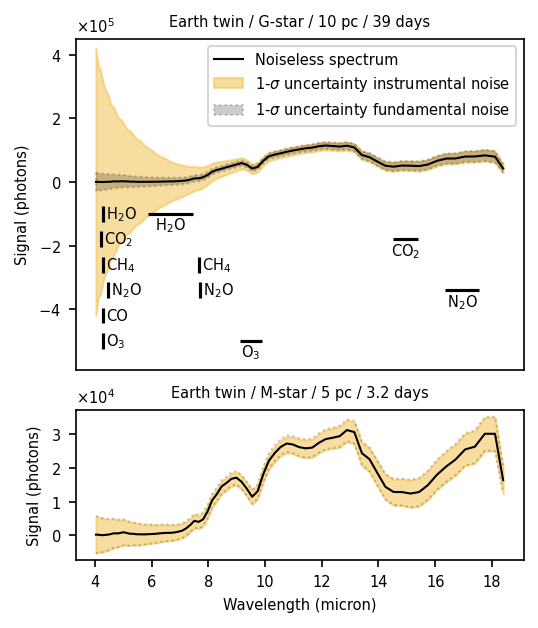

In [24]:
small_size = 7
medium_size = 9
large_size = 10

plt.rc('font', size=small_size)          # controls default text sizes
plt.rc('axes', titlesize=small_size)     # fontsize of the axes title
plt.rc('axes', labelsize=medium_size)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=small_size)    # fontsize of the tick labels
plt.rc('ytick', labelsize=small_size)    # fontsize of the tick labels
plt.rc('legend', fontsize=small_size)    # legend fontsize
plt.rc('figure', titlesize=medium_size)  # fontsize of the figure title

formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-1,1))

formatter_1 = ticker.ScalarFormatter(useMathText=True)
formatter_1.set_scientific(True)
formatter_1.set_powerlimits((-1,1))

fig, ax = plt.subplots(dpi=150, nrows=2, gridspec_kw={'height_ratios': [2.2, 1]}, figsize=(3.6, 4.2))
ax[0].ticklabel_format(style='sci')
ax[0].plot(spectrum[0]*1e6, flux_planet, c='k', lw=1, label='Noiseless spectrum')


ax[0].fill_between(res_in['wl']*1e6,
                 res_in['signal']-res_in['signal']/snr_in,
                 res_in['signal']+res_in['signal']/snr_in,
                color='#F2BD42',
                alpha=0.5, label='1-$\sigma$ uncertainty instrumental noise')

ax[0].fill_between(spectrum[0]*1e6,
                 flux_planet-flux_planet/spectrum[1],
                 flux_planet+flux_planet/spectrum[1],
                color='k',
                   ls=':',
                alpha=0.2, label='1-$\sigma$ uncertainty fundamental noise')

lh = 2.5e4
heights = {'H2O': [-2e4, -2e4],
           'CO2': [-3e4, -2e4],
           'CH4': [-4e4, -3e4],
           'N2O': [-5e4, -4e4, -2e4],
           'CO': [-6e4],
           'O3': [-7e4, -2e4]
           }

base = -1e5
step = 0.8e5
heights = {'H2O': [base-0*step, base-0*step],
           'CO2': [base-1*step, base-1*step],
           'CH4': [base-2*step, base-2*step],
           'N2O': [base-3*step, base-3*step, base-3*step],
           'CO': [base-4*step],
           'O3': [base-5*step, base-5*step]
           }

names = {'H2O': 'H$_2$O',
         'CO2': 'CO$_2$',
         'CH4': 'CH$_4$',
         'N2O': 'N$_2$O',
         'CO': 'CO',
         'O3': 'O$_3$'
         }
for k in main_bands.keys():
    for l, h in zip(main_bands[k], heights[k]):
        if (l[1]-l[0]) > 0.7:
            ax[0].hlines(xmin=l[0], xmax=l[1], y=h, alpha=1, color='k')
            ax[0].text(x=(l[1]-l[0])/2+l[0], y=h-0.7e4, s=names[k], ha='center', va='top', fontsize=small_size)
        else:
            ax[0].vlines(x=(l[1]-l[0])/2+l[0], ymin=h-lh, ymax=h+lh, alpha=1, color='k')
            ax[0].text(x=(l[1]-l[0])/2+l[0] + 0.1, y=h-0.5e3, s=names[k], ha='left', va='center', fontsize=small_size)

ax[0].legend(loc='upper right')
#ax[0].set_xlabel('Wavelength (micron)')
ax[0].set_xticks([])
ax[0].set_ylim((-5.9e5, 4.5e5))
ax[0].set_ylabel('Signal (photons)')
ax[0].yaxis.set_major_formatter(formatter)
ax[0].set_title('Earth twin / G-star / 10 pc / ' + str(int(integration_time / 60 / 60 / 24)) + ' days')

ax[1].ticklabel_format(style='sci')
ax[1].plot(spectrum_m[0]*1e6, flux_planet_m, c='k', lw=1, label='Noiseless spectrum')


ax[1].fill_between(res_in_m['wl']*1e6,
                 res_in_m['signal']-res_in_m['signal']/snr_in_m,
                 res_in_m['signal']+res_in_m['signal']/snr_in_m,
                color='#F2BD42',
                alpha=0.5, label='1-$\sigma$ uncertainty instrumental noise')

# ax[1].fill_between(spectrum_m[0]*1e6,
#                  flux_planet_m-flux_planet_m/spectrum_m[1],
#                  flux_planet_m+flux_planet_m/spectrum_m[1],
#                 color='k',
#                 alpha=0.2, label='1-$\sigma$ uncertainty fundamental noise')

ax[1].plot(spectrum_m[0]*1e6, flux_planet_m-flux_planet_m/spectrum_m[1], c='k', lw=1, ls=':', alpha=0.2)
ax[1].plot(spectrum_m[0]*1e6, flux_planet_m+flux_planet_m/spectrum_m[1], c='k', lw=1, ls=':', alpha=0.2)

#ax[1].legend(loc='upper right')
ax[1].set_xlabel('Wavelength (micron)')
ax[1].set_ylabel('Signal (photons)')
ax[1].yaxis.set_major_formatter(formatter_1)
ax[1].set_title('Earth twin / M-star / 5 pc / ' + str(np.round(integration_time_m / 60 / 60 / 24, 1)) + ' days')

fig.tight_layout()

plt.show()
fig.savefig('/Users/fdannert/Documents/projects/InLIFEsim/InLIFEsim/docs/source/paper_experiments/figures/spectrum_noise.pdf', bbox_inches='tight')